# Lineær regression - Kan vi estimere antallet af linjer

- **Problem:** Kan jeg med ML estimere antallet af linjer en FED overskrift giver anledning til? Mine input data er FED data, hvor jeg har samlet en overskrift og det tilhørende *antal* linjer strategi hørende til overskriften. Dette er et lineært problem
- **Succes er** Jeg vil undersøge om en *lidt mere avaneret model* kan finde sammenhængen.Her forsøger jeg mig med BIDIRECTIONAL recurrent GRU
- **Evaluering** Modellen evalueres ved at jeg deler data op i train, validering og test. train og validering opdeles atomatisk af Keras. Modellen valideres på *test*: Jeg plotter faktisk værdi ift predicted værdi. 
- **Data** hentes ud af FED i en tekst-fil. Den videre behandling sker i en Access-database og i et regneark. Input gemmes til sidst i et regneark
- **Baseline** Selv den bedste model har ikke rigtigt gjort det godt ind til nu, der er nok ikke system i data?
- **Optimering vs generalisering** Den får vi se på ...
- **Tuning hyper pametre** Den får vi se på ... 

Nedenfor er et par eksempler på hvordan data rigtigt ser ud. I eksemplet er en kort tekst med otte strategilinjer. Og den timsvarende omsættelse til inddata til modellen.

![title](FEDentry.GIF)

### Evaluering af forsøg

- Umiddelbart ikke bedre end LSTM, og en del overfitting
- prøver med lidt dropout, de virker bedre, men giver et dårligere resultat på test-data
### Konklusion
- Jeg har en model som virker med bidirectional
- Modellen er - ret beset - dårligere end LSTM modellen i 10b. 10b har bedre fat i at finde dem som skal være store i testsættet

In [1]:
# henter data og lægger pænt i tabeller

# vi sætter stien til data
import os
import pandas as pd
import numpy as np
os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')

# Excel-filen med tekster åbnes og indlæses
xl = pd.ExcelFile('FEDAll.xlsx')
df = xl.parse('FEDlinjer')       # siden i arket

# læs overskrifter i FED
texts  = df.loc[:,'FEDtext']
texts  = texts.values

# læs antal linjer og omsæt til "stor hændelse" eller "lille hændelse"
NumLines = df.loc[:,'FEDlinjer']
NumLines = NumLines.values

# vi rafler data rundt tilfældigt (vi laver et tilfældigt index)
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
texts   = texts[indices]
NumLines = NumLines[indices]

# opdeling i training data og test data
i = 80000  # antal linjer afsat til træning, resten er test
texts_train = texts[:i]
texts_test  = texts[i:] 
NumLines_train = NumLines[:i]
NumLines_test  = NumLines[i:]

In [2]:
# TOKENIZER - laver tekst om til vektor, henter text processing modul

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som nedenfor laves til en "one-hot")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
print('Fandt %s unikke tokens.' % len(word_index))

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Fandt 21158 unikke tokens.


In [3]:
# Stop sætninger efter dette antal ord
maxlen = 50

# sætninger laves til tekst-vektor og der "paddes"
sequences = tokenizer.texts_to_sequences(texts_train)
data_train = pad_sequences(sequences, maxlen=maxlen)
sequences = tokenizer.texts_to_sequences(texts_test)
data_test = pad_sequences(sequences, maxlen=maxlen)

# labels laves til vektor
NumLines_train = np.asarray(NumLines_train).astype('float32')
NumLines_test = np.asarray(NumLines_test).astype('float32')

# print størrelsen på train og test data
print(data_train.shape)
print(data_test.shape)
print(NumLines_train.shape)
print(NumLines_test.shape)

(80000, 50)
(20867, 50)
(80000,)
(20867,)


In [5]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.layers import Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(layers.Bidirectional(layers.GRU(32,
                                          dropout=0.1,
                                          recurrent_dropout=0.1)))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop',    # standard-optimizer
              loss='mse',             # mean square error
              metrics=['mae'])        # mean absolute error

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 8)             80000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                7872      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 87,937
Trainable params: 87,937
Non-trainable params: 0
_________________________________________________________________


In [6]:
NumEpochs = 10
history = model.fit(data_train, NumLines_train,
                    epochs=NumEpochs,
                    batch_size=512,
                    validation_split=0.2)

Train on 64000 samples, validate on 16000 samples
Epoch 1/10
64000/64000 [==============================] - 31s 486us/step - loss: 23.2600 - mean_absolute_error: 2.1711 - val_loss: 19.5327 - val_mean_absolute_error: 2.2240
Epoch 2/10
64000/64000 [==============================] - 29s 452us/step - loss: 20.7480 - mean_absolute_error: 2.0144 - val_loss: 17.7209 - val_mean_absolute_error: 2.0192
Epoch 3/10
64000/64000 [==============================] - 28s 439us/step - loss: 19.3438 - mean_absolute_error: 1.9575 - val_loss: 17.0519 - val_mean_absolute_error: 2.0282
Epoch 4/10
64000/64000 [==============================] - 29s 449us/step - loss: 18.6095 - mean_absolute_error: 1.9350 - val_loss: 16.6262 - val_mean_absolute_error: 1.8969
Epoch 5/10
64000/64000 [==============================] - 28s 442us/step - loss: 18.0609 - mean_absolute_error: 1.9118 - val_loss: 16.4388 - val_mean_absolute_error: 1.8814
Epoch 6/10
64000/64000 [==============================] - 28s 441us/step - loss: 17.6

In [7]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

In [8]:
import matplotlib.pyplot as plt
plt.show()

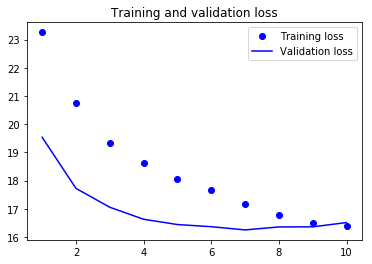

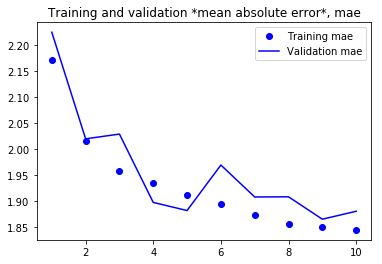

In [9]:
# plotter historikken for 'loss'
loss     = history.history['loss']
val_loss = history.history['val_loss']
mae      = history.history['mean_absolute_error']
val_mae  = history.history['val_mean_absolute_error']

epochs = range(1, NumEpochs+1)

plt.plot(epochs, loss, 'bo', label='Training loss')       # bo = "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b  = "solid blue line"
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation *mean absolute error*, mae')
plt.legend()
plt.show()

# Validering af modellen på test data
Her indlæser vi så test data, helt nye data til test

In [10]:
# vi prøver modellen på test-data
predictions = model.predict(data_test)
for i in range(1,10):
    print(('%1.4f' % predictions[i]))

3.6698
2.1542
2.3941
2.9294
2.1634
1.6071
1.6757
2.0893
2.5506


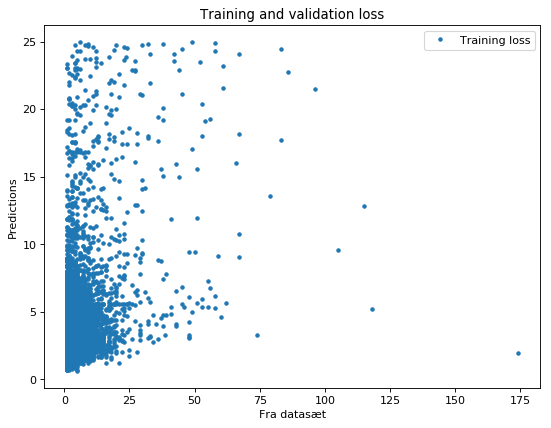

In [11]:
# plotter predictions vs 'hvad den faktisk skal være'
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(NumLines_test, predictions, '.', label='Training loss')       # bo = "blue dot"
plt.xlabel('Fra datasæt')
plt.ylabel('Predictions')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [12]:
# prøver at forstå de linjer som er små, men som får en stor prediction
print('linje   SkalVære  Prediction  Tekst')
for i in range(1,len(predictions)):
    if NumLines_test[i]<3 and predictions[i]>10:
        PrtStr = (('%5.0f' % i) + '       ' + 
                  ('%4.0f' % NumLines_test[i]) + '        ' + 
                  ('%4.1f' % predictions[i]) + '  ' + 
                  texts_test[i][:70].replace('\n', ' ').replace('\r', ''))
        print(PrtStr)

linje   SkalVære  Prediction  Tekst
   51          2        10.9  Materielfejl, holder i spor 3 og kan pt ikke køre
  170          1        12.8  TIF + PCCall: Der er i øjeblikket fejl på et sporskifte i Ringsted. De
 2115          2        12.0  Flere udfordringer fra Sverige pga. signalfejl og sporskiftefejl pga. 
 3478          1        11.3  Skinnebrud Kh sp 3/4
 4101          2        10.2  Signalfejl: Fejl på signaler ved Lund
 4146          1        11.0  Akut eftersyn af kørestrøm Roskilde sp 2 og 3
 4278          1        23.1  Har påkørt en person i Rg, spor 2. Politiet er endnu ikke fremme.
 4856          2        10.6  Materiel fejl, dør problemer , tidstab i Viby og holder nu i Rg.
 4968          2        13.3  Banedanmark    Signalfejl i HIF
 5184          1        12.9  Gj lukket indtil 12:33
 5187          2        15.9  Togstop i citytunnlen i Malmø personer i sporet
 5676          1        10.3  skal til kontrol i belv efter påkørsel af stillads ved bro  d. 27.04
 665

In [13]:
# prøver at forstå de linjer som modellen mener er store (predict > 20)
print('linje   SkalVære  Prediction  Tekst')
for i in range(1,len(predictions)):
    if predictions[i]>20:
        PrtStr = (('%5.0f' % i) + '       ' + 
                  ('%4.0f' % NumLines_test[i]) + '        ' + 
                  ('%4.0f' % predictions[i]) + '  ' + 
                  texts_test[i][:70].replace('\n', ' ').replace('\r', ''))
        print(PrtStr)

linje   SkalVære  Prediction  Tekst
  218          4          20  Materielfejl ME : holder ved I-signal i HIf med vekselretterfejl og er
  494          6          20  Disponering DSB/BDK pga. dæmningsskred spærres nordgående spor Hinneru
  554         49          25  7009 har påkørt et træ foran STS og er muligvis afsporet. Skrevet kl. 
 1066         52          24  Personpåkørsel mellem Valby og Glostrup. Vivo nr. 99024: Der kører i
 1162         12          24  SVV: Fejl på OVK 113 - viser ikke sikret for LKF, men bomme nede. Se
 1292          8          25  brand i en skråning mellem GL-Hif i retning Gl mod Hif
 1544         96          21  aflysninger og vendinger på kh spor 8 kan ikke benyttes
 1631         18          22  JORDSKRED Jelling  Ny prognose hedder at det tidligst er i orden o
 1722         61          22  Skinnebrud. Vy. 4141 melder om muligt skinnebrud i km. 40,0 Ro-Vy. Eft
 2274         24          25  Banedanmark     Stoppemaskinen har været ude at køre på svg bane